In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from joblib import dump, load
from xgboost import XGBClassifier
plt.rcParams['figure.figsize'] = [20,10]

In [5]:
data = pd.read_csv('transactions_train.csv')
responseVar = data.isFraud.to_numpy()
responseVar
data['deltaBalanceOrig'] = data.newbalanceOrig - data.oldbalanceOrig
data['deltaBalanceDest'] = -data.newbalanceDest + data.oldbalanceDest
data['prevStep'] = data['step'].shift(1)
data['prevAmt'] = data['amount'].shift(1)
data['prevType'] = 0
y = pd.get_dummies(data.type,prefix='type')
data = pd.concat([data,y],axis=1)
data['prevType_CASH_IN'] = data['type_CASH_IN'].shift(1)
data['prevType_CASH_OUT'] = data['type_CASH_OUT'].shift(1)
data['prevType_DEBIT'] = data['type_DEBIT'].shift(1)
data['prevType_PAYMENT'] = data['type_PAYMENT'].shift(1)
data['prevType_TRANSFER'] = data['type_TRANSFER'].shift(1)

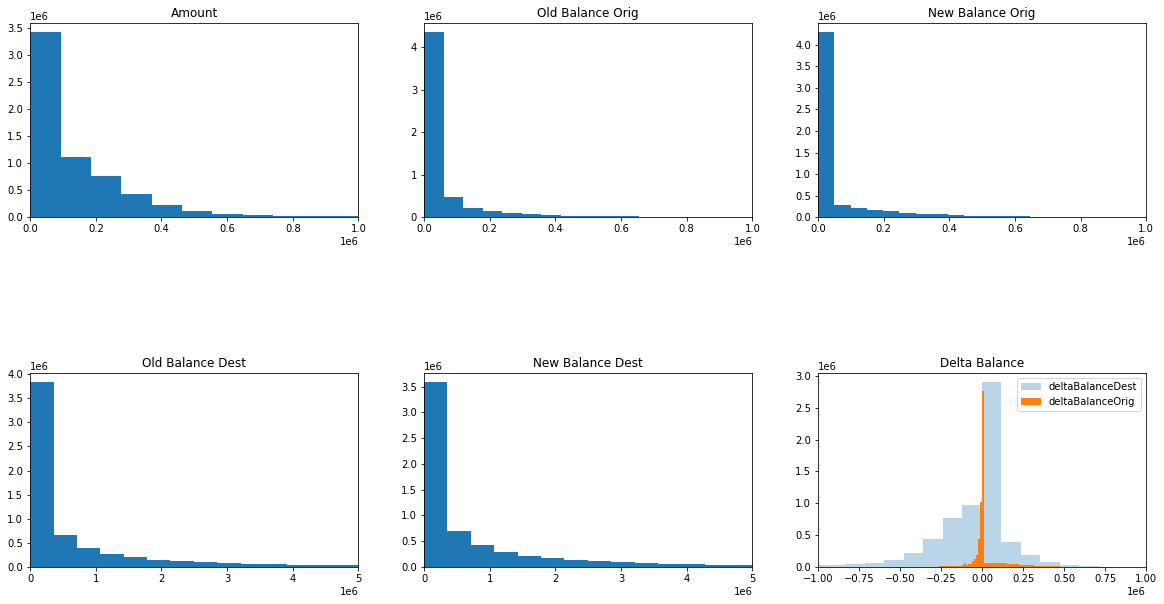

In [3]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3)
fig.subplots_adjust(hspace=0.8)
ax.hist(x=data['amount'],bins=1000,label='amount')
ax.set_xlim(0,1e6)
ax.set_title('Amount')
ax1.hist(x=data['oldbalanceOrig'],bins=1000,label='oldbalanceOrig')
ax1.set_xlim(0,1e6)
ax1.set_title('Old Balance Orig')
ax2.hist(x=data['newbalanceOrig'],bins=1000,label='newbalanceOrig')
ax2.set_xlim(0,1e6)
ax2.set_title('New Balance Orig')
ax3.hist(x=data['oldbalanceDest'],bins=1000,label='oldbalanceDest')
ax3.set_xlim(0,0.5e7)
ax3.set_title('Old Balance Dest')
ax4.hist(x=data['newbalanceDest'],bins=1000,label='newbalanceDest')
ax4.set_xlim(0,0.5e7)
ax4.set_title('New Balance Dest')
ax5.hist(x=data['deltaBalanceDest'],bins=1000,label='deltaBalanceDest',alpha=0.3)
ax5.hist(x=data['deltaBalanceOrig'],bins=1000,label='deltaBalanceOrig')
ax5.set_xlim(-1e6,1e6)
ax5.set_title('Delta Balance')
ax5.legend()

plt.show()

In [20]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,prevType_CASH_IN,prevType_CASH_OUT,prevType_DEBIT,prevType_PAYMENT,prevType_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0


In [21]:
features = data.loc[:,['amount','deltaBalanceDest','step', 'oldbalanceOrig',
                       'newbalanceOrig','newbalanceDest','oldbalanceDest',
                       'deltaBalanceOrig','prevAmt','prevStep','type_CASH_IN',
                       'type_CASH_OUT','type_DEBIT','type_PAYMENT',
                       'type_TRANSFER','prevType_CASH_IN','prevType_CASH_OUT',
                       'prevType_DEBIT','prevType_PAYMENT','prevType_TRANSFER',]]
features.shape

(6351193, 20)

In [22]:
features

,amount,deltaBalanceDest,step,oldbalanceOrig,newbalanceOrig,newbalanceDest,oldbalanceDest,deltaBalanceOrig,prevAmt,prevStep,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,prevType_CASH_IN,prevType_CASH_OUT,prevType_DEBIT,prevType_PAYMENT,prevType_TRANSFER
0,9839.64,0.00,1,170136.00,160296.36,0.00,0.00,-9839.64,NaN,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
1,1864.28,0.00,1,21249.00,19384.72,0.00,0.00,-1864.28,9839.64,1.0,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0
2,181.00,0.00,1,181.00,0.00,0.00,0.00,-181.00,1864.28,1.0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0
3,181.00,21182.00,1,181.00,0.00,0.00,21182.00,-181.00,181.00,1.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
4,11668.14,0.00,1,41554.00,29885.86,0.00,0.00,-11668.14,181.00,1.0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,162326.52,0.00,699,162326.52,0.00,0.00,0.00,-162326.52,573.88,699.0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0
6351189,162326.52,-162326.52,699,162326.52,0.00,162326.52,0.00,-162326.52,162326.52,699.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
6351190,2763398.31,0.00,699,2763398.31,0.00,0.00,0.00,-2763398.31,162326.52,699.0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0
6351191,2763398.31,-2763398.31,699,2763398.31,0.00,3102913.66,339515.35,-2763398.31,2763398.31,699.0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0


In [23]:
seed = 42
Xtrain,Xtest,ytrain,ytest = train_test_split(features,responseVar,test_size=0.2,stratify=responseVar, random_state=seed)

In [25]:
mdl = XGBClassifier(use_label_encoder=False,verbosity=2)
mdl.fit(Xtrain,ytrain)

[17:31:21] INFO: ../src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[17:31:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:31:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[17:31:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[17:37:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:37:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:37:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:37:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:37:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[17:37:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:37:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:37:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=2)

In [26]:
mdl.score(Xtrain,ytrain)

0.9999946860373071

In [27]:
preds = mdl.predict(Xtest)
acc = accuracy_score(ytest,preds)
f1 = f1_score(ytest,preds)
prec = precision_score(ytest,preds)
recall = recall_score(ytest,preds)
AUC = roc_auc_score(ytest,preds)
print(acc, f1, prec, recall, AUC)

0.9999771696507508 0.9906179230022647 0.9890180878552972 0.9922229423201555 0.9961047713675348


In [ ]:
dump(mdl,'XGBoostModelFeatures14.joblib')

In [28]:
print(np.c_[features.columns,mdl.feature_importances_])

[['amount' 0.02535092830657959]
 ['deltaBalanceDest' 0.05511711537837982]
 ['step' 0.013048981316387653]
 ['oldbalanceOrig' 0.050720129162073135]
 ['newbalanceOrig' 0.09714874625205994]
 ['newbalanceDest' 0.1653953343629837]
 ['oldbalanceDest' 0.005194817669689655]
 ['deltaBalanceOrig' 0.04250821843743324]
 ['prevAmt' 0.02517349272966385]
 ['prevStep' 0.0023232002276927233]
 ['type_CASH_IN' 0.0]
 ['type_CASH_OUT' 0.09467646479606628]
 ['type_DEBIT' 0.0]
 ['type_PAYMENT' 0.008309495635330677]
 ['type_TRANSFER' 0.11804746091365814]
 ['prevType_CASH_IN' 0.0016668356256559491]
 ['prevType_CASH_OUT' 0.00217917887493968]
 ['prevType_DEBIT' 0.0]
 ['prevType_PAYMENT' 0.0014349689008668065]
 ['prevType_TRANSFER' 0.29170462489128113]]


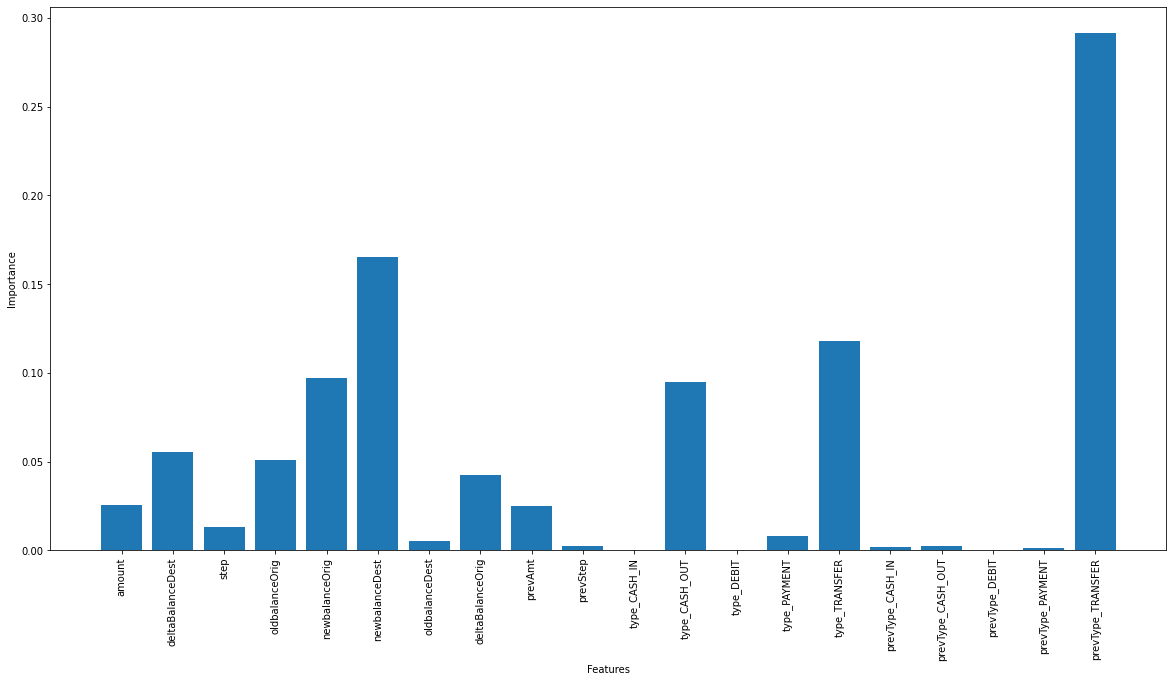

In [29]:
plt.bar(features.columns,mdl.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

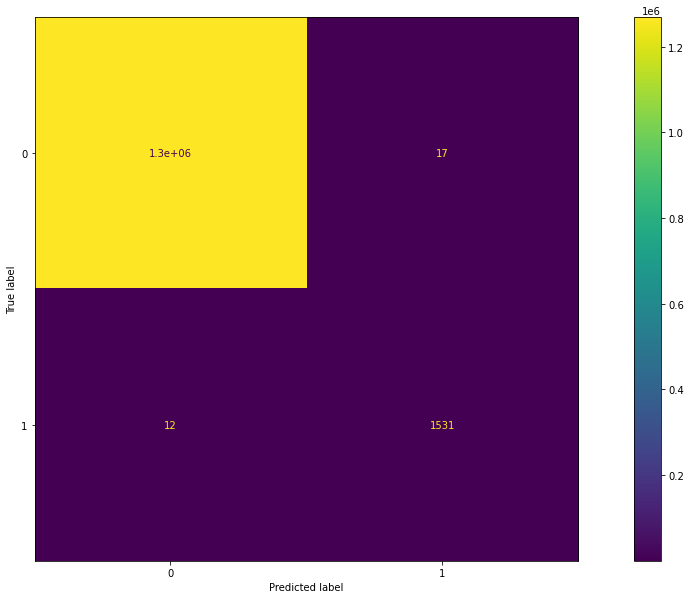

In [30]:
cm = confusion_matrix(ytest, preds, labels=mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mdl.classes_)
disp.plot()
plt.show()

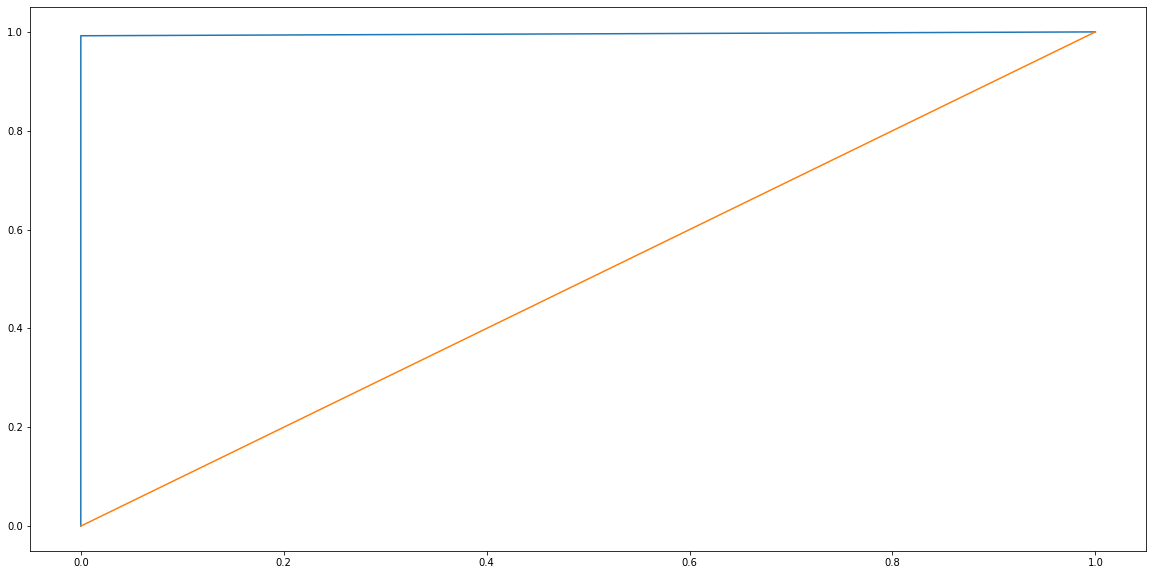

In [31]:
fpr, tpr, thresh = roc_curve(ytest,preds)
f, ax = plt.subplots(1)
ax.plot(fpr,tpr)
ax.plot([0,1])
plt.show()